In [ ]:
client.shutdown()

In [1]:
import ipyparallel as ipp
cluster = ipp.Cluster(engines="MPI", n=4) # starts the clusters
client = cluster.start_and_connect_sync()
client.ids

Starting 4 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 4/4 [00:12<00:00,  3.05s/engine]


[0, 1, 2, 3]

In [2]:
%%px
from mpi4py import MPI
comm = MPI.COMM_WORLD
print('Rank {} of {} is alive.'.format(comm.Get_rank(), comm.Get_size())) # Test clusters

[stdout:0] Rank 0 of 4 is alive.


[stdout:2] Rank 2 of 4 is alive.


[stdout:3] Rank 3 of 4 is alive.


[stdout:1] Rank 1 of 4 is alive.


In [3]:
%%px
import numpy as np
import matplotlib.pyplot as plt
import time as time
NX = 150
NY = 150

comm = MPI.COMM_WORLD      # start the communicator assign to comm
size = comm.Get_size()     # get the size and assign to size
rank = comm.Get_rank()     # get the rank and assign to rank

sectsY=int(np.floor(np.sqrt(size)))
sectsX=int(size/sectsY)
if rank == 0: print('In the case of equal size we divide the processes as {} and {}'.format(sectsX,sectsY))

cartcomm = comm.Create_cart(dims=[sectsX, sectsY], periods=[False, False], reorder=False)
rcoords = cartcomm.Get_coords(rank)

sR, dR = cartcomm.Shift(1, 1)
sL, dL = cartcomm.Shift(1, -1)
sU, dU = cartcomm.Shift(0, -1)
sD, dD = cartcomm.Shift(0, 1)

sd = np.array([sR, dR, sL, dL, sU, dU, sD, dD], dtype= int)

allrcoords = comm.gather(rcoords,root = 0)
allDestSourBuf = np.zeros(size*8, dtype = int)
comm.Gather(sd, allDestSourBuf, root = 0)

if rank == 0:
    print(' ')
    cartarray = np.ones((sectsY,sectsX),dtype=int)
    allDestSour = np.array(allDestSourBuf).reshape((size,8))
    for i in np.arange(size):
        cartarray[allrcoords[i][0],allrcoords[i][1]] = i
        print('Rank {} all destinations and sources {}'.format(i,allDestSour[i,:]))
        sR,dR,sL,dL,sU,dU,sD,dD = allDestSour[i]
        print('Rank {} is at {}'.format(i,allrcoords[i]))
        print('sour/dest right {} {}'.format(sR,dR))
        print('sour/dest left  {} {}'.format(sL,dL))  
        print('sour/dest up    {} {}'.format(sU,dU))
        print('sour/dest down  {} {}'.format(sD,dD))
        print('[stdout:',i,']',allDestSour[i])
    print(' ')
    print(cartarray)

def Communicate(c, cartcomm, sd):
    """
    Performs the communication between each rank

    Parameters
    ----------
    c : np.array()
        f_eq array
    cartcomm : Cartcomm
        Cartesian communicator
    sd : np.array()
        Consists of tuples for data shifting in rank
    """
    #recvbuf = np.zeros(c[:, :, 1].shape)
    sR, dR, sL, dL, sU, dU, sD, dD = sd

    #print(rank,'Right, source',sR,'destination',dR)
    # Send from left, receive on right
    sendbuf = c[:, :, -2].copy()
    recvbuf = c[:, :, 0].copy()
    cartcomm.Sendrecv(sendbuf=sendbuf,dest= dR, recvbuf=recvbuf, source = sR)
    c[:, :, 0] = recvbuf
    
    #print(rank,'Left, source',sL,'destination',dL)
    # Send from right, receive on left
    sendbuf = c[:, :, 1].copy()
    recvbuf = c[:, :, -1].copy()
    cartcomm.Sendrecv(sendbuf=sendbuf,dest=dL, recvbuf=recvbuf, source = sL)
    c[:, :, -1] = recvbuf

    #print(rank,'Up, source',sU,'destination',dU)
    # Send from bottom, receive on top
    sendbuf = c[:, 1, :].copy()
    recvbuf = c[:, -1, :].copy()
    cartcomm.Sendrecv(sendbuf=sendbuf, dest=dU, recvbuf=recvbuf, source = sU)
    c[:, -1, :] = recvbuf

    #print(rank,'Down, source',sD,'destination',dD)
    # Send from top, receive on bottom
    sendbuf = c[:, -2, :].copy()
    recvbuf = c[:, 0, :].copy()
    cartcomm.Sendrecv(sendbuf=sendbuf, dest=dD, recvbuf=recvbuf, source = sD)
    c[:, 0, :] = recvbuf

    return c

 
# f equilibrium
def calculate_eq_dist(rho_nm, u_anm, c_ai, w_i):
    """
    Calculates the equilibrium distribution

    Parameters
    ----------
    rho_nm : np.array()
        density array
    u_anm : np.array()
        velocity array
    c_ai : np.array()
        velocity channels direction
    w_i: np.array()
        weights for each velocity channel
    """
    u_anm_x_u_anm = np.einsum('anm, anm->nm', u_anm, u_anm) # u^2
    c_ai_x_u_anm = np.einsum('ai,anm->inm', c_ai, u_anm)    # c x u
    cu_sq = c_ai_x_u_anm**2                                 # (c x u)^2
    wrho_inm = np.einsum('i,nm->inm', w_i, rho_nm)          # w x rho
    f_eq = wrho_inm * (1 + 3 * c_ai_x_u_anm + 4.5 * cu_sq - 1.5 * u_anm_x_u_anm)
    return f_eq

def collision(f_inm, c_ai, w_i, omega):
    """
    Calculates collision between each particle

    Parameters
    ----------
    f_inm : np.array()
        f equilibrium 
    c_ai : np.array()
        velocity channels direction
    w_i: np.array()
        weights for each velocity channel
    omega: float
        Omega value, usually 1.3
    """
    rho_nm = np.einsum('inm->nm', f_inm)                     # calculate density
    u_anm = np.einsum('ia,inm->anm', c_ai.T, f_inm) / rho_nm # calculate average velocity
    f_eq = calculate_eq_dist(rho_nm, u_anm, c_ai, w_i)
    f_inm += ((f_eq - f_inm) * omega)
    return f_inm, u_anm, rho_nm

def streaming_operator(f_inm, c_ai):
    """
    Streaming for all nine channels &
    store the old and transformed f_inm

    Parameters
    ----------
    f_inm : np.array()
        f equilibrium 
    c_ai : np.array()
        velocity channels direction
    """
    new_f_inm = np.empty_like(f_inm)
    np.copyto(new_f_inm, f_inm)
    for i in np.arange(1, 9): 
        
        new_f_inm[i] = np.roll(new_f_inm[i], shift = c_ai.T[i], axis = (0, 1))

    return new_f_inm, f_inm

def all_wall(new_f_inm, f_inm, u_anm, c_ai, wall_velocity, has_boundary):
    """
    boundary conditions for all 4 walls (moving top wall, other 4 is rigid)

    Parameters
    ----------
    new_f_inm : np.array()
        transformed f equilibrium 
    f_inm : np.array()
        old f equilibrium 
    u_anm : np.array()
        velocity array
    c_ai : np.array()
        velocity channels direction
    wall_velocity : float
        wall velocity x-direction value
    has_boundary : np.array()

    """
    opposite = np.array([0, 3, 4, 1, 2, 7, 8, 5, 6])
    # bottom wall
    if has_boundary[2]:
        for i in np.array([4, 7, 8]):
            new_f_inm[opposite[i], -1, :] = f_inm[i, -1, :].copy() 
    # right wall
    if has_boundary[1]:
        for i in np.array([1, 5, 8]):
            new_f_inm[opposite[i], :, -1] = f_inm[i, :, -1].copy()
    # left wall
    if has_boundary[0]:
        for i in np.array([3, 6, 7]):
            new_f_inm[opposite[i], :, 0] = f_inm[i, :, 0].copy()

    u = [0, wall_velocity]
    rho_nm = np.einsum('inm->nm', f_inm)
    rho_mean = np.mean(rho_nm)
    sound_speed_squared = (1/np.sqrt(3))**2
    
    if has_boundary[3]:
        for i in np.array([2, 5, 6]):
            new_f_inm[opposite[i], 0, :] = (f_inm[i, 0, :] - 2 * w_i[i] * rho_mean * (c_ai[:, i] @ u) / sound_speed_squared).copy()
    return new_f_inm

def save_mpiio(comm, fn, g_kl):
    """
    Write a global two-dimensional array to a single file in the npy format
    using MPI I/O: https://docs.scipy.org/doc/numpy/neps/npy-format.html

    Arrays written with this function can be read with numpy.load.

    Parameters
    ----------
    comm
        MPI communicator.
    fn : str
        File name.
    g_kl : array_like
        Portion of the array on this MPI processes. This needs to be a
        two-dimensional array.
    """
    from numpy.lib.format import dtype_to_descr, magic
    magic_str = magic(1, 0)

    local_nx, local_ny = g_kl.shape
    nx = np.empty_like(local_nx)
    ny = np.empty_like(local_ny)

    commx = comm.Sub((True, False))
    commy = comm.Sub((False, True))
    commx.Allreduce(np.asarray(local_nx), nx)
    commy.Allreduce(np.asarray(local_ny), ny)

    arr_dict_str = str({ 'descr': dtype_to_descr(g_kl.dtype),
                         'fortran_order': False,
                         'shape': (nx.item(), ny.item()) })
    while (len(arr_dict_str) + len(magic_str) + 2) % 16 != 15:
        arr_dict_str += ' '
    arr_dict_str += '\n'
    header_len = len(arr_dict_str) + len(magic_str) + 2

    offsetx = np.zeros_like(local_nx)
    commx.Exscan(np.asarray(ny*local_nx), offsetx)
    offsety = np.zeros_like(local_ny)
    commy.Exscan(np.asarray(local_ny), offsety)

    file = MPI.File.Open(comm, fn, MPI.MODE_CREATE | MPI.MODE_WRONLY)
    if comm.Get_rank() == 0:
        file.Write(magic_str)
        file.Write(np.int16(len(arr_dict_str)))
        file.Write(arr_dict_str.encode('latin-1'))
    mpitype = MPI._typedict[g_kl.dtype.char]
    filetype = mpitype.Create_vector(g_kl.shape[0], g_kl.shape[1], ny)
    filetype.Commit()
    file.Set_view(header_len + (offsety+offsetx)*mpitype.Get_size(),
                  filetype=filetype)
    file.Write_all(g_kl.copy())
    filetype.Free()
    file.Close()

nt = 10000
omega = 1.3

# initialize 
w_i = np.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36]) #weights
c_ai = np.array([[0, 0, -1, 0, 1, -1, -1, 1, 1],
                [0, 1, 0, -1, 0, 1, -1, -1, 1]])
# initialize gridpoints
nxsub = NX//sectsX+2
nysub = NY//sectsY+2
rho_ij = np.ones((nxsub, nysub))
u_anm = np.zeros((2, nxsub, nysub)) # velocity field
vel_field = np.empty((nt, 2, NX//sectsX, NY//sectsY))
wall_velocity = 0.15

# Define boundaries at each domain
has_boundary = [False,False,False,False] # [Left,Right,Down,Up]
if rcoords[0] == sectsX-1: has_boundary[2] = True # if True then there is a boundary to the bottom of this subdomain.
if rcoords[1] == sectsY-1: has_boundary[1] = True # if True then there is a boundary to the right of this subdomain.
if rcoords[1] == 0: has_boundary[0] = True # if True then there is a boundary to the left of this subdomain.
if rcoords[0] == 0: has_boundary[3] = True # if True then there is a boundary to the top of this subdomain.

print(f"rank: {rank}")

# Start of execution
f_inm = calculate_eq_dist(rho_ij, u_anm, c_ai, w_i)


start_time = time.time()
for t in np.arange(nt):
    f_inm, u_anm, rho_ij = collision(f_inm, c_ai, w_i, omega)
    
    f_inm = Communicate(f_inm, cartcomm, sd)
    new_f_inm, f_inm = streaming_operator(f_inm, c_ai)
    
    f_inm = all_wall(new_f_inm, f_inm, u_anm, c_ai, wall_velocity, has_boundary)
   
save_mpiio(cartcomm, 'ux.npy', u_anm[0, 1:-1, 1:-1])
save_mpiio(cartcomm, 'uy.npy', u_anm[1, 1:-1, 1:-1])
end_time = time.time()
# End of execution

runttime = end_time - start_time
if rank == 0:
    print(f"total time {runttime}")
    mlups = NX * NY * nt / runttime

[stdout:2] rank: 2


[stdout:0] In the case of equal size we divide the processes as 2 and 2
 
Rank 0 all destinations and sources [-1  1  1 -1  2 -1 -1  2]
Rank 0 is at [0, 0]
sour/dest right -1 1
sour/dest left  1 -1
sour/dest up    2 -1
sour/dest down  -1 2
[stdout: 0 ] [-1  1  1 -1  2 -1 -1  2]
Rank 1 all destinations and sources [ 0 -1 -1  0  3 -1 -1  3]
Rank 1 is at [0, 1]
sour/dest right 0 -1
sour/dest left  -1 0
sour/dest up    3 -1
sour/dest down  -1 3
[stdout: 1 ] [ 0 -1 -1  0  3 -1 -1  3]
Rank 2 all destinations and sources [-1  3  3 -1 -1  0  0 -1]
Rank 2 is at [1, 0]
sour/dest right -1 3
sour/dest left  3 -1
sour/dest up    -1 0
sour/dest down  0 -1
[stdout: 2 ] [-1  3  3 -1 -1  0  0 -1]
Rank 3 all destinations and sources [ 2 -1 -1  2 -1  1  1 -1]
Rank 3 is at [1, 1]
sour/dest right 2 -1
sour/dest left  -1 2
sour/dest up    -1 1
sour/dest down  1 -1
[stdout: 3 ] [ 2 -1 -1  2 -1  1  1 -1]
 
[[0 1]
 [2 3]]
rank: 0
total time 48.06145668029785


[stdout:3] rank: 3


[stdout:1] rank: 1


%px: 100%|██████████| 4/4 [00:47<00:00, 11.93s/tasks]


[stdout:0] (150, 150)


[output:0]

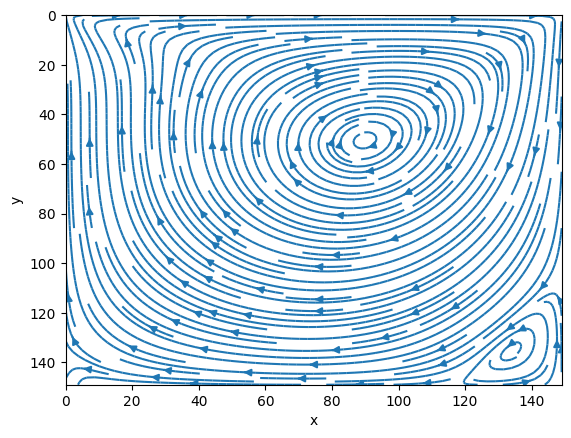

In [5]:
%%px

L = 150
viscosity = 1/3 * ((1/omega) - 0.5)
Re = NX * wall_velocity / viscosity
omega = 1 / (3*viscosity + 0.5)

NX = 150
NY = 150

if rank == 0:
    fig, ax = plt.subplots()
    ax.invert_yaxis()
    ax.set_title(f"")
    ax.set_ylabel("y")
    ax.set_xlabel("x")
    x = np.arange(NX)
    y = np.arange(NY)

    #plt.suptitle("Sliding Lid with 9 Processes", fontweight="bold")
    u = np.load('ux.npy')
    v = np.load('uy.npy')
    print(u.shape)

    norm = plt.Normalize(0, wall_velocity)
    ax.streamplot(x, y, v, u,
                norm=norm,
                density=2.0)

    plt.show()